### 用Mini-Batch Gradient Descent实现逻辑回归。

In [1]:
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [2]:
import tensorflow as tf
tf.__version__

'1.10.1'

In [3]:
from sklearn.datasets import make_moons

m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

In [4]:
X_moons.shape

(1000, 2)

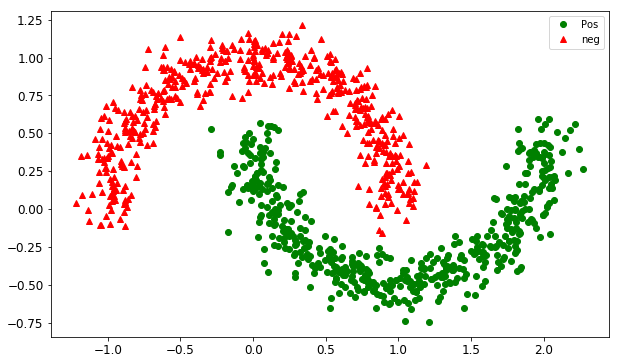

In [5]:
# take a peek at the dataset:
plt.figure(figsize=(10, 6))
plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label='Pos')
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label='neg')
plt.legend()
plt.show()

In [6]:
# Add the bias to every instance
X_moons_with_bias = np.c_[np.ones((m, 1)), X_moons]

In [7]:
X_moons_with_bias[:5]

array([[ 1.        , -0.05146968,  0.44419863],
       [ 1.        ,  1.03201691, -0.41974116],
       [ 1.        ,  0.86789186, -0.25482711],
       [ 1.        ,  0.288851  , -0.44866862],
       [ 1.        , -0.83343911,  0.53505665]])

In [8]:
y_moons.shape

(1000,)

In [9]:
y_moons[:50]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1])

In [10]:
# Reshape y_train to make it a column vector 
# i.e. a 2D array with a single column
y_moons_column_vec = y_moons.reshape((-1, 1))

In [11]:
y_moons_column_vec.shape

(1000, 1)

In [12]:
y_moons_column_vec[:10]

array([[1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0]])

In [13]:
# Split the dataset into a training set and a test set
test_ratio = 0.2
test_size = int(m * test_ratio)

X_train = X_moons_with_bias[:-test_size]
X_test = X_moons_with_bias[-test_size:]
y_train = y_moons_column_vec[:-test_size]
y_test = y_moons_column_vec[-test_size:]

In [14]:
X_train.shape

(800, 3)

Generate training batches. In this implementation, I just pick random instances from the training set for each batch. This means that a single batch may contain the same instance multiple times, and also a single epoch may not cover all the training instances (in fact, it will generally cover only about two thirds of the instances). However, in practice this is not an issue and it simplifies the code:

In [15]:
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

In [16]:
X_batch, y_batch = random_batch(X_train, y_train, 5)
X_batch

array([[ 1.        , -0.8788657 ,  0.57862084],
       [ 1.        ,  2.03231695,  0.04097405],
       [ 1.        ,  1.21809433, -0.39160026],
       [ 1.        ,  1.0631328 ,  0.23986563],
       [ 1.        ,  1.72726811, -0.31756229]])

In [17]:
y_batch

array([[0],
       [1],
       [1],
       [0],
       [1]])

In [18]:
n_inputs = 2   # moon dataset's features

In [19]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name='X')
y = tf.placeholder(tf.float32, shape=(None, 1), name='y')
theta = tf.Variable(tf.random_uniform((n_inputs + 1, 1), -1., 1., seed=42),
                    name='theta')
logits = tf.matmul(X, theta, name='logit')
y_proba = 1 / (1 + tf.exp(-logits))

In [20]:
y_proba = tf.sigmoid(logits)   # TF function

**The log loss is good cost function to use for Logistic Regrssion:**

$J(\boldsymbol{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} \log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) \log\left(1 - \hat{p}^{(i)}\right)\right]}$

In [21]:
# implement it ourselves:
epsilon = 1e-7   # to avoid an overflow when computing the log
loss = -tf.reduce_mean(y * tf.log(y_proba + epsilon) +
                       (1 - y) * tf.log(1 - y_proba + epsilon))

In [22]:
# use TF
loss = tf.losses.log_loss(y, y_proba)   # use epsilon=1e-7 as default

In [23]:
# create the optimizer and tell it to minimize the cost func
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

In [24]:
# the variable initializer
init = tf.global_variables_initializer()

In [25]:
n_epochs = 1000
batch_size = 64
n_batches = int(np.ceil(len(X_train) / batch_size))

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = loss.eval({X: X_batch, y: y_batch})
        if epoch % 100 == 0:
            print('Epoch:', epoch, "\tloss:", loss_val)
    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

Epoch: 0 	loss: 0.8438206
Epoch: 100 	loss: 0.3899342
Epoch: 200 	loss: 0.354181
Epoch: 300 	loss: 0.2816858
Epoch: 400 	loss: 0.26364976
Epoch: 500 	loss: 0.18626454
Epoch: 600 	loss: 0.30963647
Epoch: 700 	loss: 0.2304509
Epoch: 800 	loss: 0.3422131
Epoch: 900 	loss: 0.301583


In [26]:
y_proba_val.shape

(200, 1)

In [27]:
y_proba_val.reshape(-1).shape

(200,)

In [28]:
y_proba_val[:5]

array([[0.5245573 ],
       [0.72607267],
       [0.49420372],
       [0.9865433 ],
       [0.5172419 ]], dtype=float32)

In [29]:
y_pred = (y_proba_val >= 0.5)
y_pred[:5]

array([[ True],
       [ True],
       [False],
       [ True],
       [ True]])

> Depending on the use case, you may want to choose a different threshold than 0.5: make it higher if you want high precision (but lower recall), and make it lower if you want high recall (but lower precision). 

In [30]:
from sklearn.metrics import recall_score, precision_score

precision_score(y_test, y_pred)

0.8514851485148515

In [31]:
recall_score(y_test, y_pred)

0.8686868686868687

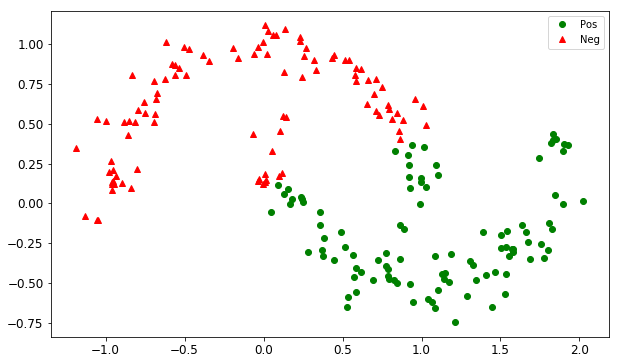

In [32]:
# Plot the preds to see what they look like:
y_pred_idx = y_pred.reshape(-1)  # a 1D array rather than a column vec

plt.figure(figsize=(10, 6))
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label='Pos')
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label='Neg')
plt.legend()
plt.show()

> 不好。但是Logistic Regression模型是一个线性决策边界，这个结果已经是用这个模型最好的结果了。

**重新开始:**
+ 在函数`logistic_regression()`定义可以被复用的graph
+ 在训练过程中，定期地通过`Saver`将检查点保存起来，并将最后的模型保存起来
+ 用合理的作用域来定义graph，使得其在TB中look good
+ 添加汇总信息以在TB中可视化learning curve
+ 调整learning_rate和mini-batch size这些超参数，并查看学习曲线的形状。

In [33]:
X_train_enhanced = np.c_[X_train,
                         np.square(X_train[:, 1]),
                         np.square(X_train[:, 2]),
                         X_train[:, 1] ** 3,
                         X_train[:, 2] ** 3]
X_test_enhanced = np.c_[X_test,
                        X_test[:, 1] ** 2,
                        X_test[:, 2] ** 2,
                        X_test[:, 1] ** 3,
                        X_test[: ,2] ** 3]

In [34]:
X_train_enhanced[:5]

array([[ 1.00000000e+00, -5.14696757e-02,  4.44198631e-01,
         2.64912752e-03,  1.97312424e-01, -1.36349734e-04,
         8.76459084e-02],
       [ 1.00000000e+00,  1.03201691e+00, -4.19741157e-01,
         1.06505890e+00,  1.76182639e-01,  1.09915879e+00,
        -7.39511049e-02],
       [ 1.00000000e+00,  8.67891864e-01, -2.54827114e-01,
         7.53236288e-01,  6.49368582e-02,  6.53727646e-01,
        -1.65476722e-02],
       [ 1.00000000e+00,  2.88850997e-01, -4.48668621e-01,
         8.34348982e-02,  2.01303531e-01,  2.41002535e-02,
        -9.03185778e-02],
       [ 1.00000000e+00, -8.33439108e-01,  5.35056649e-01,
         6.94620746e-01,  2.86285618e-01, -5.78924095e-01,
         1.53179024e-01]])

In [35]:
# Reset the graph
reset_graph()

Now let's define the `logistic_regression()` function to create the graph. We will leave out the definition of the inputs X and the targets y. We could include them here, but leaving them out will make it easier to use this function in a wide range of use cases (e.g. perhaps we will want to add some preprocessing steps for the inputs before we feed them to the Logistic Regression model).

In [36]:
# Define the logistic regression func to create graph
def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[-1])

    with tf.name_scope('logistic_regression'):
        with tf.name_scope('model'):
            if initializer is None:
                initializer = tf.random_uniform((n_inputs_including_bias, 1),
                                                -1., 1., seed=seed)
            theta = tf.Variable(initializer, name='theta')
            logits = tf.matmul(X, theta, name='logits')
            y_proba = tf.sigmoid(logits)
            
        with tf.name_scope('train'):
            loss = tf.losses.log_loss(y, y_proba, scope='loss')
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        
        with tf.name_scope('init'):
            init = tf.global_variables_initializer()
        
        with tf.name_scope('save'):
            saver = tf.train.Saver()
    return y_proba, loss, training_op, loss_summary, init, saver

In [37]:
# Create a little func to get the name of the log directory to save the summaries fo TB
from datetime import datetime


def log_dir(prefix=""):
    now = datetime.utcnow().strftime('%Y%m%d%H%M%S')
    root_logdir = 'tf_logs'
    if prefix:
        prefix += '-'
    name = prefix + 'run' + now
    return "{}/{}/".format(root_logdir, name)

In [38]:
# Create the graph using the logistic_regression func
n_inputs = 2 + 4
logdir = log_dir('logreg')

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name='X')
y = tf.placeholder(tf.float32, shape=(None, 1), name='y')

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

In [39]:
# Create the FileWriter to save the summaries to the log directory for TB
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

**Train the model.** We will start by checking whether a previous training session was interrupted, and if so we will load the checkpoint and continue training from the epoch number we saved. In this example we just save the epoch number to a separate file

In [40]:
n_epochs = 10001
batch_size = 64
n_batches = int(np.ceil(len(X_train_enhanced) / batch_size))

checkpoint_path = '/home/bingli/Codes/handson_ml_dl/my_logreg_model.ckpt'
checkpoint_epoch_path = checkpoint_path + '.epoch'
final_model_path = '/home/bingli/Codes/my_logreg_model'

In [41]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, 'rb') as f:
            start_epoch = int(f.read())
        print('Training was interrupted. Continuing at epoch', start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)
    
    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary],
                                         feed_dict={X: X_test_enhanced, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tloss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, 'wb') as f:
                f.write(b"%d" % (epoch + 1))
    
    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    os.remove(checkpoint_epoch_path)

Epoch: 0 	loss: 0.6370542
Epoch: 500 	loss: 0.18973479
Epoch: 1000 	loss: 0.1447225
Epoch: 1500 	loss: 0.1204854
Epoch: 2000 	loss: 0.10467823
Epoch: 2500 	loss: 0.093299635
Epoch: 3000 	loss: 0.08484332
Epoch: 3500 	loss: 0.07818744
Epoch: 4000 	loss: 0.072843306
Epoch: 4500 	loss: 0.06839817
Epoch: 5000 	loss: 0.06469286
Epoch: 5500 	loss: 0.06151434
Epoch: 6000 	loss: 0.05877262
Epoch: 6500 	loss: 0.056341704
Epoch: 7000 	loss: 0.05422868
Epoch: 7500 	loss: 0.05237229
Epoch: 8000 	loss: 0.05070669
Epoch: 8500 	loss: 0.049194712
Epoch: 9000 	loss: 0.047803182
Epoch: 9500 	loss: 0.046529304
Epoch: 10000 	loss: 0.045400366


In [42]:
y_pred = (y_proba_val >= 0.5)

In [43]:
precision_score(y_test, y_pred)

0.9797979797979798

In [44]:
recall_score(y_test, y_pred)

0.9797979797979798

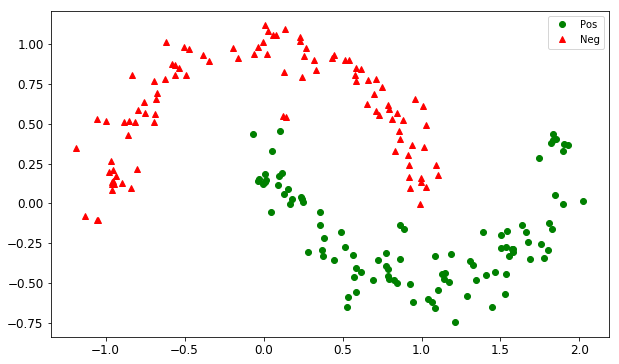

In [45]:
# Plot the preds to see what they look like:
y_pred_idx = y_pred.reshape(-1)  # a 1D array rather than a column vec

plt.figure(figsize=(10, 6))
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label='Pos')
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label='Neg')
plt.legend()
plt.show()

**随机搜索learning_rate和batch_size：**

In [48]:
from scipy.stats import reciprocal

n_search_interations = 10

for search_interation in range(n_search_interations):
    batch_size = np.random.randint(1, 100)
    learning_rate = reciprocal(0.0001, 0.1).rvs(random_state=search_interation)

    n_inputs = 2 + 4
    logdir = log_dir('logreg')

    print('Interation', search_interation)
    print('   logdir:', logdir)
    print('   batch size:', batch_size)
    print('   learning_rate:', learning_rate)
    print('   training:', end='')

    reset_graph()

    X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name='X')
    y = tf.placeholder(tf.float32, shape=(None, 1), name='y')

    y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(
        X, y, learning_rate=learning_rate)
    
    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
    
    n_epochs = 10001
    b_batches = int(np.ceil(len(X_train_enhanced) / batch_size))
    
    final_model_path = '/home/bingli/Codes/my_logreg_model_%d' % search_interation
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(n_epochs):
            for batch_index in range(n_batches):
                X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            loss_val, summary_str = sess.run([loss, loss_summary],
                                             feed_dict={X: X_test_enhanced, y: y_test})
            file_writer.add_summary(summary_str, epoch)
            if epoch % 500 == 0:
                print(".", end="")
        
        saver.save(sess, final_model_path)
        
        print()
        y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
        y_pred = (y_proba_val >= 0.5)
        
        print("   precision:", precision_score(y_test, y_pred))
        print("   recall:", recall_score(y_test, y_pred))

Interation 0
   logdir: tf_logs/logreg-run20181008080855/
   batch size: 54
   learning_rate: 0.004430375245218265
   training:.....................
   precision: 0.9797979797979798
   recall: 0.9797979797979798
Interation 1
   logdir: tf_logs/logreg-run20181008081046/
   batch size: 37
   learning_rate: 0.0017826497151386947
   training:.....................
   precision: 0.9696969696969697
   recall: 0.9696969696969697
Interation 2
   logdir: tf_logs/logreg-run20181008081237/
   batch size: 17
   learning_rate: 0.00203228544324115
   training:.....................
   precision: 0.9696969696969697
   recall: 0.9696969696969697
Interation 3
   logdir: tf_logs/logreg-run20181008081426/
   batch size: 81
   learning_rate: 0.004491523825137997
   training:.....................
   precision: 0.9797979797979798
   recall: 0.9797979797979798
Interation 4
   logdir: tf_logs/logreg-run20181008081618/
   batch size: 38
   learning_rate: 0.07963234721775589
   training:.....................
   p

The `reciprocal()` func from SciPy's stats module returns a random distribution that is commonly used when u have no idea of the optimal scale of a hyperparameter. 